# For quick tests

In [71]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

import tigramite
import tigramite.data_processing
import tigramite.plotting

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# =====================================================

path_project = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_tcdf = path_project + '/src'
path_datasets = path_project + '/datasets'
path_tcdf_bash = path_tcdf.replace(' ', '\\ ')
path_datasets_bash = path_datasets.replace(' ', '\\ ')
sys.path.append(path_tcdf)
from TCDF_wrapper import TCDF

# =====================================================

dataset = path_datasets + '/generated/gen_ts.csv'
dataset_gt = path_datasets + '/generated/gen_ts_groundtruth.csv'

TCDF_solver = TCDF(significance=1.0, epochs=1000)
TCDF_solver.fit(dataset, normalize='minmax', verbose=2)

TCDF_solver.get_causes()
TCDF_solver.check_with_ground_truth(dataset_gt)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Analysis started for target:  x0
Epoch:  1 [0%] 	Loss: 0.189275
Epoch: 500 [50%] 	Loss: 0.001121
Epoch: 1000 [100%] 	Loss: 0.000995
Potential causes: [0, 1]


⎡ diff = first_loss - real_loss
| 0.1882799428422004 = 0.18927498161792755 - 0.0009950387757271528
| 
| testdiff = first_loss - test_loss
⎣ 0.16278043203055859 = 0.18927498161792755 - 0.026494549587368965


⎡ diff = first_loss - real_loss
| 0.1882799428422004 = 0.18927498161792755 - 0.0009950387757271528
| 
| testdiff = first_loss - test_loss
⎣ 0.1812562681734562 = 0.18927498161792755 - 0.00801871344447136


Validated causes: [0, 1]

Analysis started for target:  x1
Epoch:  1 [0%] 	Loss: 0.270514
Epoch: 500 [50%] 	Loss: 0.004346
Epoch: 1000 [100%] 	Loss: 0.004311
Potential causes: [3, 1]


⎡ diff = first_loss - real_loss
| 0.2662036595866084 = 0.27051421999931335 - 0.004310560412704945
| 
| testdiff = first_loss - test_loss
⎣ 0.26085533387959

In [89]:
TCDF_solver.get_causes(graphical=True)
TCDF_solver.check_with_ground_truth(dataset_gt)


========================== RESULTS =========================

x0 ---> x0 (d = 1)
x1 ---> x0 (d = 1)
x3 ---> x1 (d = 1)
x1 ---> x1 (d = 1)
x2 ---> x2 (d = 1)
x3 ---> x3 (d = 1)
x1 ---> x3 (d = 0)



======================== EVALUATION ========================

⎡ Total directions: 8
⎢ 
⎢ Correct connections: 7
⎢ Correct directions: 6
⎢ Incorrect connections: [0, set()]
⎢ Incorrect directions: [1, {(1, 3)}]
⎣ Undetected connections: [2, {(2, 3), (2, 1)}]


⎡ Delays
⎢ 
⎢ Correct: 6
⎢ Incorrect AND correct direction: [0, set()]
⎣ Correct AND incorrect direction: [0, set()]




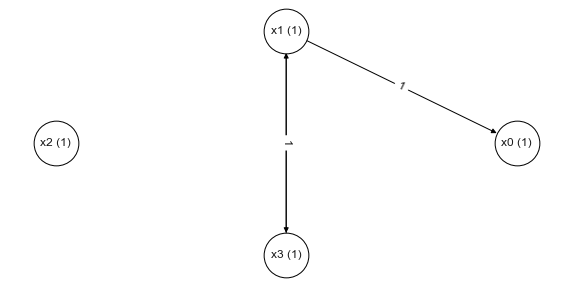

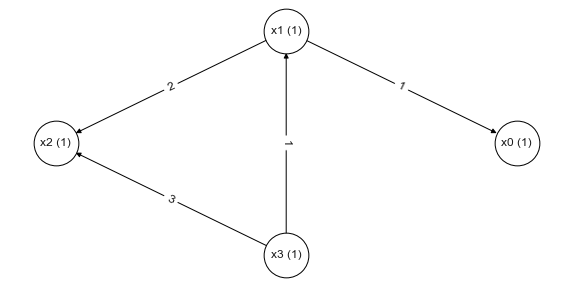

In [4]:
TCDF_solver.plot_graph(ground_truth=dataset_gt)
# TCDF_solver.visualize_weights(targets='x0', pointwise=True, attention_scores=True)

# Causal discovery of time series

Tigramite + TCDF tests

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

path_project = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_tcdf = path_project + '/src'
path_datasets = path_project + '/datasets'
path_tcdf_bash = path_tcdf.replace(' ', '\\ ')
path_datasets_bash = path_datasets.replace(' ', '\\ ')


sys.path.append(path_tcdf)
# sys.path

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import tigramite
import tigramite.data_processing
import tigramite.plotting

from TCDF_wrapper import TCDF

sns.set(style='darkgrid')

## Time-series generation. Basic example.

Consider a dynamical system, which generates time series coming from a data generating process. 

\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-1} + \eta^0_t\\
X^1_t &= 0.8 X^1_{t-1} + 0.8 X^3_{t-1} + \eta^1_t\\
X^2_t &= 0.5 X^2_{t-1} + 0.5 X^1_{t-2} + 0.6 X^3_{t-3} + \eta^2_t\\
X^3_t &= \eta^3_t\\
\end{align*}

where $\eta$ are independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable.

In [32]:
def generate_ar_process(links_coeffs, time_steps, seed=None):
  if seed is not None:
    np.random.seed(seed)
  return tigramite.data_processing.var_process(links_coeffs, T=time_steps)

def binarize(array, threshold):
  """
  https://stackoverflow.com/questions/33756995/fastest-way-to-filter-values-in-np-array-based-on-changing-threshold
  """
  thresholds = np.full(data.shape, threshold)
  binarized = np.empty(data.shape)

  for slice in range(data.shape[1]):
    binarized[:, slice] = list(map(lambda x: 1 if x == True else 0, (data > thresholds)[:, slice]))
  return binarized

In [33]:
time_steps, num_timeseries = 1000, 4 # exactly data.shape
time_grid = np.arange(time_steps)

links_coeffs = { 0: [((0, -1), 0.7), ((1, -1), -0.8)],
                 1: [((1, -1), 0.8), ((3, -1), 0.8)],
                 2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                 3: [((3, -1), 0.1)],
               }

data, true_parents_neighbors = generate_ar_process(links_coeffs, time_steps)
# data_binarized = binarize(data, 0.5)

In [34]:
print(np.shape(data)[0])
print(data)

np.savetxt(path_datasets + '/generated/gen_ts.csv', data, header='x0,x1,x2,x3', comments='', delimiter=',')

1000
[[-0.4144878  -2.04492572  0.77822383  1.44561179]
 [-0.21004822 -1.6271807  -1.81730677  1.21674525]
 [ 2.11932955 -0.8980383   0.79555867  0.90314771]
 ...
 [ 2.7027574  -0.07120249 -1.48013937  0.20514913]
 [ 1.64829392 -1.57777682 -0.59544864 -0.58691168]
 [ 2.90357052 -2.92100208 -0.81447061 -0.67627742]]


## TCDF in Jupyter

In [5]:
dataset = path_datasets + '/generated/gen_ts.csv'
dataset_gt = path_datasets + '/generated/gen_ts_groundtruth.csv'

In [6]:
TCDF_solver = TCDF(significance=1.0)
TCDF_solver.fit(dataset, normalize='minmax', verbose=2)


Analysis started for target:  x0
Epoch:  1 [0%] 	Loss: 0.382983
Epoch: 500 [50%] 	Loss: 0.001523
Epoch: 1000 [100%] 	Loss: 0.001236
Potential causes: [0, 1]

⎡ diff = first_loss - real_loss
| 0.3817467864137143 = 0.3829827606678009 - 0.0012359742540866137
|
| testdiff = first_loss - test_loss
⎣ 0.36773108318448067 = 0.3829827606678009 - 0.015251677483320236


⎡ diff = first_loss - real_loss
| 0.3817467864137143 = 0.3829827606678009 - 0.0012359742540866137
|
| testdiff = first_loss - test_loss
⎣ 0.37213279213756323 = 0.3829827606678009 - 0.010849968530237675

Validated causes: [0, 1]

Analysis started for target:  x1
Epoch:  1 [0%] 	Loss: 0.273464
Epoch: 500 [50%] 	Loss: 0.004328
Epoch: 1000 [100%] 	Loss: 0.004153
Potential causes: [3, 1]

⎡ diff = first_loss - real_loss
| 0.26931108767166734 = 0.27346375584602356 - 0.004152668174356222
|
| testdiff = first_loss - test_loss
⎣ 0.2638415424153209 = 0.27346375584602356 - 0.009622213430702686


⎡ diff = first_loss - real_loss
| 0.269311087

In [7]:
TCDF_solver.get_causes()
TCDF_solver.check_with_ground_truth(dataset_gt)


========================== RESULTS =========================

x0 causes x0 with a delay of 1 time steps.
x1 causes x0 with a delay of 1 time steps.
x3 causes x1 with a delay of 1 time steps.
x1 causes x1 with a delay of 1 time steps.
x2 causes x2 with a delay of 1 time steps.
x1 causes x2 with a delay of 2 time steps.
x1 causes x3 with a delay of 0 time steps.
x0 causes x3 with a delay of 0 time steps.



======================== EVALUATION ========================

⎡ Total connections: 8
|
| Correct connections: 6
| Incorrect connections: (1, {(3, 0)})
| Incorrect directions: (0, set())
⎣ Undetected connections: (2, {(2, 3), (3, 3)})

⎡ Delays
|   Correct: 6
|   Incorrect AND correct direction: 0
⎣   Correct AND incorrect direction: 0





In [8]:
TCDF_solver.models['x3'].fs_attention.data.numpy()

array([[1.220224  ],
       [1.1611232 ],
       [0.87076867],
       [0.6033991 ]], dtype=float32)

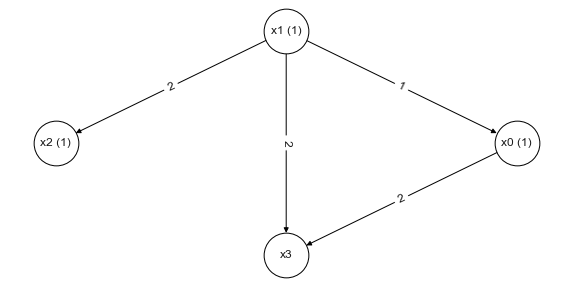

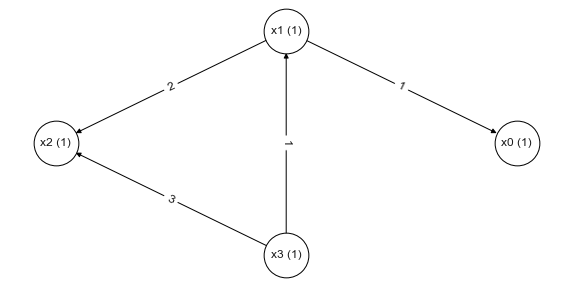

In [9]:
TCDF_solver.plot_graph(ground_truth=dataset_gt)

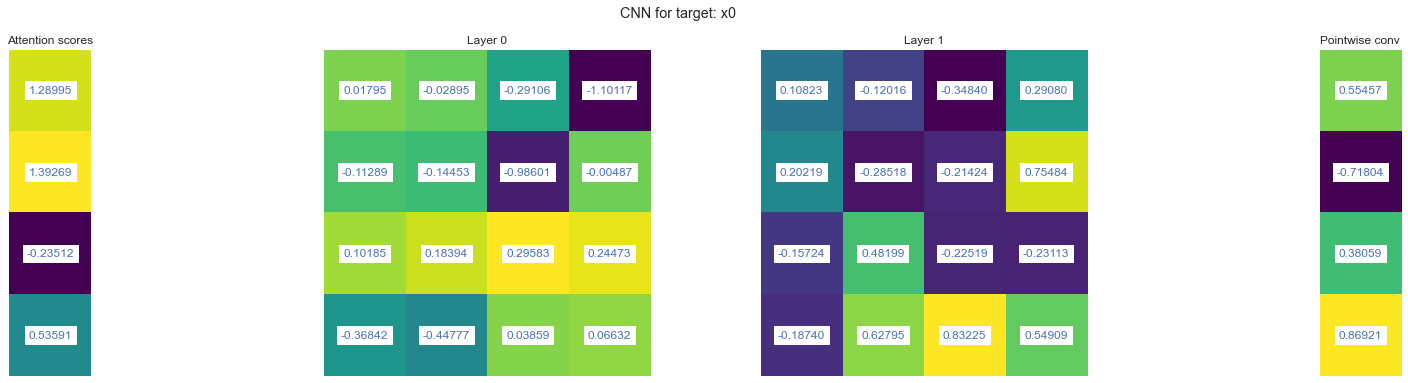

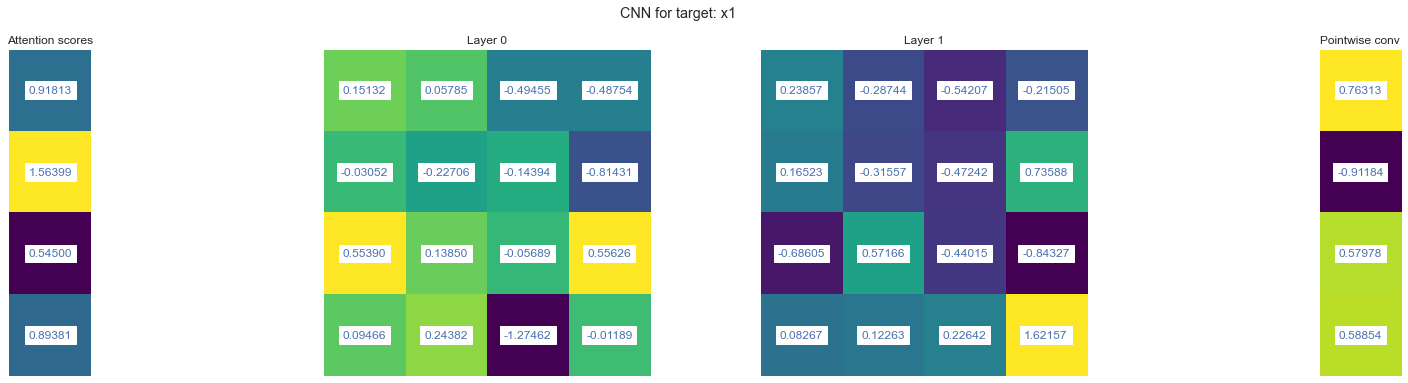

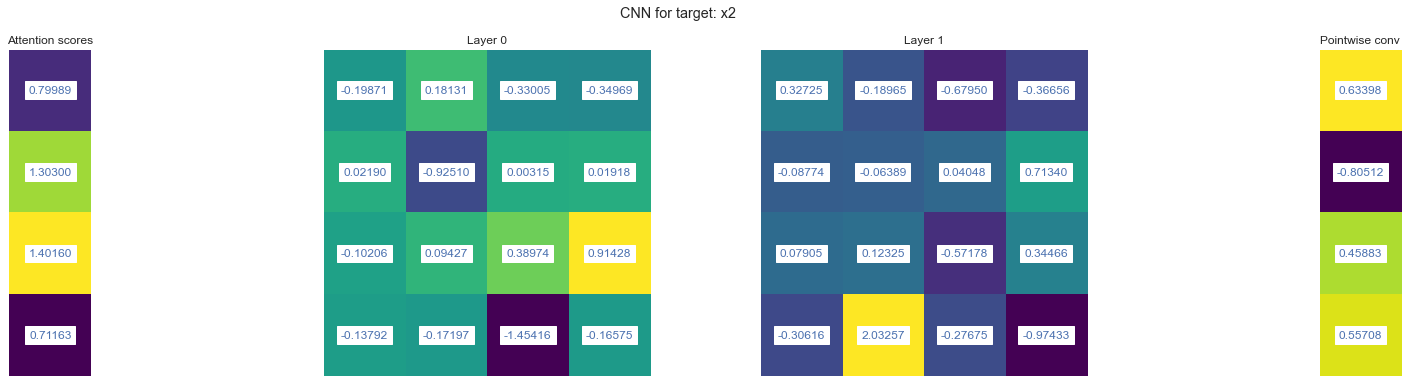

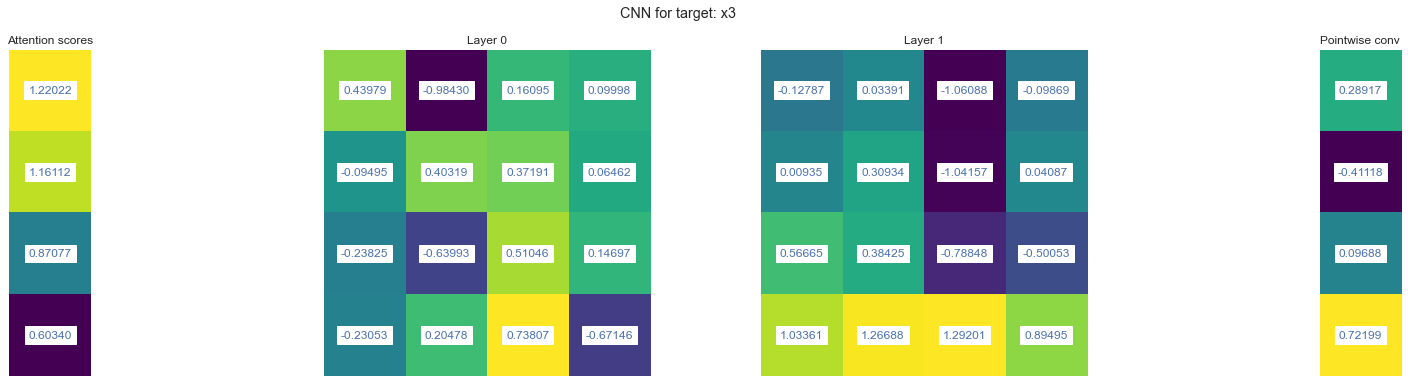

In [10]:
TCDF_solver.visualize_weights(pointwise=True, attention_scores=True)

## git task 1 ([link](https://github.com/sataset/TCDF-mod/projects/1#card-40348639))

Test TCDF on generated AR processes

### Test 1

Test two separately generated and check if TCDF distinguishes them

In [32]:
time_steps, num_timeseries = 1000, 4
time_grid = np.arange(time_steps)
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
links_coeffs = { 0: [((0, -1), 0.7), ((1, -1), -0.8)],
                 1: [((1, -1), 0.8)],
                 2: [((2, -1), 0.5), ((1, -2), 0.5)],
               }
num_data = 2
header = ','.join([f'x{i}' for i in range(num_data * len(links_coeffs))])

data_1, _ = generate_ar_process(links_coeffs, time_steps)
data_2, _ = generate_ar_process(links_coeffs, time_steps)

data = np.concatenate((data_1, data_2), axis=1)

root_path = os.getcwd()
os.makedirs(f'{path_datasets}/generated/task_01', exist_ok=True)
path_test = path_datasets + '/generated/task_01/gen_ts.csv'
np.savetxt(path_test, data, header=header, comments='', delimiter=',')


Analysis started for target:  x0
Potential causes: [0, 1]
Validated causes: [0, 1]

Analysis started for target:  x1
Potential causes: [1, 0]
Validated causes: [1, 0]

Analysis started for target:  x2
Potential causes: [2, 1]
Validated causes: [2, 1]

Analysis started for target:  x3
Potential causes: [4, 5]
Validated causes: [4, 5]

Analysis started for target:  x4
Potential causes: [4, 3, 0]
Validated causes: [4, 3, 0]

Analysis started for target:  x5
Potential causes: [5, 4, 3]
Validated causes: [5, 4, 3]

========================== RESULTS =========================

x0 causes x0 with a delay of 1 time steps.
x1 causes x0 with a delay of 1 time steps.
x1 causes x1 with a delay of 1 time steps.
x0 causes x1 with a delay of 0 time steps.
x2 causes x2 with a delay of 1 time steps.
x1 causes x2 with a delay of 2 time steps.
x4 causes x3 with a delay of 1 time steps.
x5 causes x3 with a delay of 0 time steps.
x4 causes x4 with a delay of 1 time steps.
x3 causes x4 with a delay of 0 tim

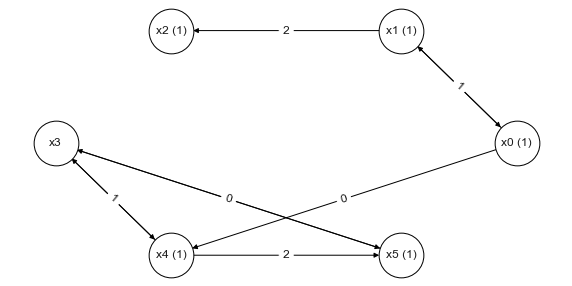

In [33]:
TCDF_solver = TCDF(significance=1, kernel_size=4, dilation_coefficient=4, hidden_layers=0)
TCDF_solver.fit(path_test, verbose=1)

TCDF_solver.get_causes()
# TCDF_solver.check_with_ground_truth(dataset_gt)

TCDF_solver.plot_graph()
# TCDF_solver.visualize_weights(pointwise=True, attention_scores=True)


Analysis started for target:  x0
Potential causes: [0, 1]
Validated causes: [0]

Analysis started for target:  x1
Potential causes: [1, 0]
Validated causes: [1]

Analysis started for target:  x2
Potential causes: [2, 1]
Validated causes: [2, 1]

Analysis started for target:  x3
Potential causes: [4, 5]
Validated causes: [4]

Analysis started for target:  x4
Potential causes: [4, 3, 0]
Validated causes: [4]

Analysis started for target:  x5
Potential causes: [5, 4, 3]
Validated causes: [5, 4]

========================== RESULTS =========================

x0 causes x0 with a delay of 1 time steps.
x1 causes x1 with a delay of 1 time steps.
x2 causes x2 with a delay of 1 time steps.
x1 causes x2 with a delay of 2 time steps.
x4 causes x3 with a delay of 1 time steps.
x4 causes x4 with a delay of 1 time steps.
x5 causes x5 with a delay of 1 time steps.
x4 causes x5 with a delay of 2 time steps.




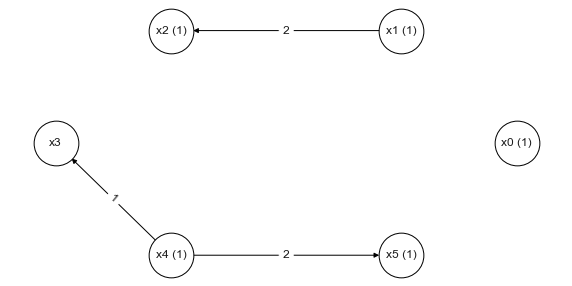

In [34]:
TCDF_solver = TCDF(significance=0.8, kernel_size=4, dilation_coefficient=4, hidden_layers=0)
TCDF_solver.fit(path_test, verbose=1)

TCDF_solver.get_causes()
TCDF_solver.plot_graph()
# TCDF_solver.visualize_weights(pointwise=True, attention_scores=True)

### Conclusion on test 1

Specific parameters should be set, but works by default on simple example

### Test 2

Check if accuracy will improve after deleting unnecessary data

In [166]:
seed = 13

In [167]:
# data gen: approach 1

links_coeffs = { 0: [((0, -1), 0.7), ((1, -1), -0.8)],
                 1: [((1, -1), 0.8)],
                 2: [((2, -1), 0.5), ((1, -2), 0.5)],
                 3: [((3, -1), 0.7), ((4, -1), -0.8)],
                 4: [((4, -1), 0.8)],
                 5: [((5, -1), 0.5), ((4, -2), 0.5)],
               }
dependencies = { 'x0': ['x0', 'x1'],
                 'x1': ['x1'],
                 'x2': ['x2', 'x1'],
                 'x3': ['x3', 'x4'],
                 'x4': ['x4'],
                 'x5': ['x5', 'x4'],
               }

ground_truth = pd.DataFrame([[0, 0, 1],
                             [1, 0, 1],
                             [1, 1, 1],
                             [1, 2, 2],
                             [2, 2, 1],
                             [3, 3, 1],
                             [4, 3, 1],
                             [4, 4, 1],
                             [4, 5, 2],
                             [5, 5, 1]],
                            columns=['cause', 'effect', 'delay'])

header = ','.join([f'x{i}' for i in list(links_coeffs.keys())] )

data, _ = generate_ar_process(links_coeffs, time_steps=1000, seed=seed)

path_test = path_datasets + '/generated/task_01'
os.makedirs(path_test, exist_ok=True)
ground_truth.to_csv(path_test + '/gen_ts_gt.csv', index=False)
np.savetxt(path_test + '/gen_ts_1.csv', data, header=header, comments='', delimiter=',')

In [207]:
# data gen: approach 2

links_coeffs = { 0: [((0, -1), 0.7), ((1, -1), -0.8)],
                 1: [((1, -1), 0.8)],
                 2: [((2, -1), 0.5), ((1, -2), 0.5)],
               }

dependencies = { 'x0': ['x0', 'x1'],
                 'x1': ['x1'],
                 'x2': ['x2', 'x1'],
                 'x3': ['x3', 'x4'],
                 'x4': ['x4'],
                 'x5': ['x5', 'x4'],
               }

ground_truth = pd.DataFrame([[0, 0, 1],
                             [1, 0, 1],
                             [1, 1, 1],
                             [1, 2, 2],
                             [2, 2, 1],
                             [3, 3, 1],
                             [4, 3, 1],
                             [4, 4, 1],
                             [4, 5, 2],
                             [5, 5, 1]],
                            columns=['cause', 'effect', 'delay'])

data_num = 2
header = ','.join([f'x{i}' for i in range(data_num * len(links_coeffs))] )

data_1, _ = generate_ar_process(links_coeffs, time_steps=1000, seed=seed)
data_2, _ = generate_ar_process(links_coeffs, time_steps=1000, seed=seed + 1)
data = np.concatenate((data_1, data_2), axis=1)

path_test = path_datasets + '/generated/task_01'
os.makedirs(path_test, exist_ok=True)
ground_truth.to_csv(path_test + '/gen_ts_gt.csv', index=False)
np.savetxt(path_test + '/gen_ts_2.csv', data, header=header, comments='', delimiter=',')

In [177]:
# data gen: approach 3

links_coeffs_1 = { 0: [((0, -1), 0.7), ((1, -1), -0.8)],
                   1: [((1, -1), 0.8)],
                   2: [((2, -1), 0.5), ((1, -2), 0.5)],
                 }
links_coeffs_2 = { 3: [((3, -1), 0.7), ((4, -1), -0.8)],
                   4: [((4, -1), 0.8)],
                   5: [((5, -1), 0.5), ((4, -2), 0.5)],
                 }
dependencies = { 'x0': ['x0', 'x1'],
                 'x1': ['x1'],
                 'x2': ['x2', 'x1'],
                 'x3': ['x3', 'x4'],
                 'x4': ['x4'],
                 'x5': ['x5', 'x4'],
               }

ground_truth = pd.DataFrame([[0, 0, 1],
                             [1, 0, 1],
                             [1, 1, 1],
                             [1, 2, 2],
                             [2, 2, 1],
                             [3, 3, 1],
                             [4, 3, 1],
                             [4, 4, 1],
                             [4, 5, 2],
                             [5, 5, 1]],
                            columns=['cause', 'effect', 'delay'])

header = ','.join([f'x{i}' for i in list(links_coeffs_1.keys()) + list(links_coeffs_2.keys())] )

data_1, _ = generate_ar_process(links_coeffs_1, time_steps=1000, seed=seed)
data_2, _ = generate_ar_process(links_coeffs_2, time_steps=1000, seed=seed + 1)
data = np.concatenate((data_1, data_2), axis=1)

path_test = path_datasets + '/generated/task_01'
os.makedirs(path_test, exist_ok=True)
ground_truth.to_csv(path_test + '/gen_ts_gt.csv', index=False)
np.savetxt(path_test + '/gen_ts_3.csv', data, header=header, comments='', delimiter=',')


========================== RESULTS =========================

x0 causes x0 with a delay of 1 time steps.
x1 causes x0 with a delay of 1 time steps.
x1 causes x1 with a delay of 1 time steps.
x2 causes x2 with a delay of 1 time steps.
x1 causes x2 with a delay of 2 time steps.
x3 causes x3 with a delay of 1 time steps.
x4 causes x3 with a delay of 1 time steps.
x4 causes x4 with a delay of 1 time steps.
x5 causes x5 with a delay of 1 time steps.
x4 causes x5 with a delay of 2 time steps.



======================== EVALUATION ========================

⎡ Counts
|
| True Positives: 10
| False Positives: 0
| False Negatives: 0
| Direct True Positives: 10
⎣ Direct False Positives: 0

⎡ True Positives: [(0, 0), (0, 1), (1, 1), (2, 2), (2, 1), (3, 3), (3, 4), (4, 4), (5, 5), (5, 4)]
| False Positives: []
| False Negatives: []
| True Positives (direct): [(0, 0), (0, 1), (1, 1), (2, 2), (2, 1), (3, 3), (3, 4), (4, 4), (5, 5), (5, 4)]
⎣ False Positives (direct): []

⎡ F1 score (includes direct 

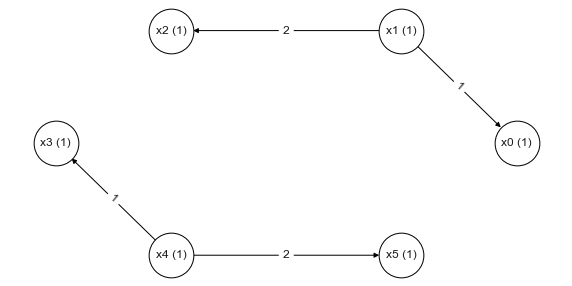

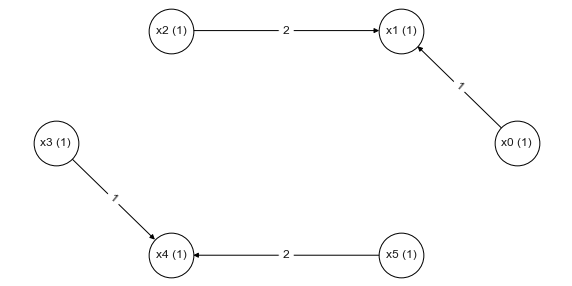

In [170]:
TCDF_solver = TCDF(significance=0.8, kernel_size=4, dilation_coefficient=4, hidden_layers=0)
TCDF_solver.fit(path_test + '/gen_ts_1.csv', verbose=0)

TCDF_solver.get_causes()
TCDF_solver.check_with_ground_truth(path_test + '/gen_ts_gt.csv')
TCDF_solver.plot_graph(ground_truth=path_test + '/gen_ts_gt.csv')


========================== RESULTS =========================

x0 causes x0 with a delay of 1 time steps.
x1 causes x0 with a delay of 1 time steps.
x1 causes x1 with a delay of 1 time steps.
x2 causes x2 with a delay of 1 time steps.
x1 causes x2 with a delay of 2 time steps.
x3 causes x3 with a delay of 1 time steps.
x4 causes x3 with a delay of 1 time steps.
x4 causes x4 with a delay of 1 time steps.
x5 causes x5 with a delay of 1 time steps.
x4 causes x5 with a delay of 2 time steps.



======================== EVALUATION ========================

⎡ Counts
|
| True Positives: 10
| False Positives: 0
| False Negatives: 0
| Direct True Positives: 10
⎣ Direct False Positives: 0

⎡ True Positives: [(0, 0), (0, 1), (1, 1), (2, 2), (2, 1), (3, 3), (3, 4), (4, 4), (5, 5), (5, 4)]
| False Positives: []
| False Negatives: []
| True Positives (direct): [(0, 0), (0, 1), (1, 1), (2, 2), (2, 1), (3, 3), (3, 4), (4, 4), (5, 5), (5, 4)]
⎣ False Positives (direct): []

⎡ F1 score (includes direct 

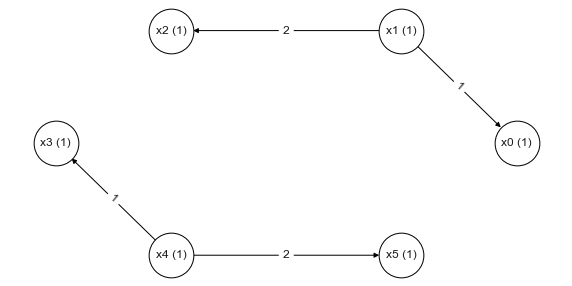

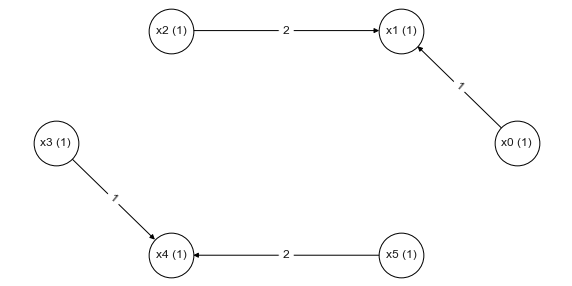

In [208]:
TCDF_solver = TCDF(significance=0.8, kernel_size=4, dilation_coefficient=4, hidden_layers=0)
TCDF_solver.fit(path_test + '/gen_ts_2.csv', verbose=0)

TCDF_solver.get_causes()
TCDF_solver.check_with_ground_truth(path_test + '/gen_ts_gt.csv')
TCDF_solver.plot_graph(ground_truth=path_test + '/gen_ts_gt.csv')


========================== RESULTS =========================

x3 causes x0 with a delay of 1 time steps.
x1 causes x1 with a delay of 2 time steps.
x4 causes x1 with a delay of 1 time steps.
x4 causes x2 with a delay of 2 time steps.
x5 causes x2 with a delay of 1 time steps.
x3 causes x2 with a delay of 2 time steps.
x3 causes x3 with a delay of 1 time steps.
x4 causes x3 with a delay of 1 time steps.
x4 causes x4 with a delay of 1 time steps.
x5 causes x5 with a delay of 1 time steps.
x4 causes x5 with a delay of 2 time steps.



======================== EVALUATION ========================

0.5454545454545454 0.6
⎡ Counts
|
| True Positives: 6
| False Positives: 5
| False Negatives: 4
| Direct True Positives: 6
⎣ Direct False Positives: 5

⎡ True Positives: [(1, 1), (3, 3), (3, 4), (4, 4), (5, 5), (5, 4)]
| False Positives: [(0, 3), (1, 4), (2, 4), (2, 5), (2, 3)]
| False Negatives: [(0, 0), (0, 1), (2, 1), (2, 2)]
| True Positives (direct): [(1, 1), (3, 3), (3, 4), (4, 4), (5, 5), 

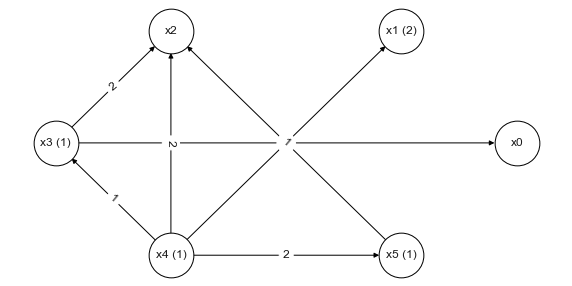

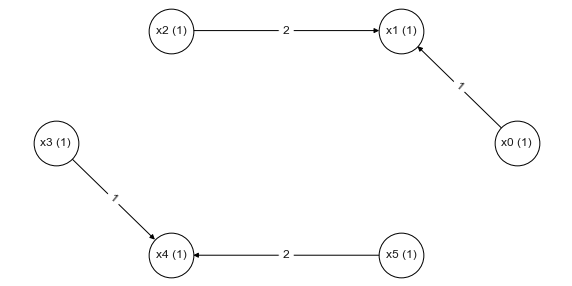

In [179]:
TCDF_solver = TCDF(significance=0.8, kernel_size=4, dilation_coefficient=4, hidden_layers=0)
TCDF_solver.fit(path_test + '/gen_ts_3.csv', verbose=0)

TCDF_solver.get_causes()
TCDF_solver.check_with_ground_truth(path_test + '/gen_ts_gt.csv')
TCDF_solver.plot_graph(ground_truth=path_test + '/gen_ts_gt.csv')

In [211]:
import torch

def prepare_data(dataframe, target, dependencies):
    """Reads data from csv file and transforms it to two PyTorch tensors:
    dataset x and target time series y that has to be predicted."""
    df_y = dataframe.copy(deep=True)[[target]]
    df_y_shift = df_y.copy(deep=True).shift(periods=1, axis=0)
    df_y_shift[target] = df_y_shift[target].fillna(0.)

    df_x = dataframe.copy(deep=True)
    df_x[target] = df_y_shift
    df_x_only_causes = df_x.copy(deep=True)

    for i in df.columns:
        if i not in dependencies:
            df_x_only_causes[i] = 0.
    
    data_x_only_causes = df_x_only_causes.values.astype('float32').transpose()
    data_x = df_x.values.astype('float32').transpose()
    data_y = df_y.values.astype('float32').transpose()
    
    x_only_causes = torch.from_numpy(data_x_only_causes)
    x = torch.from_numpy(data_x)
    y = torch.from_numpy(data_y)

    return x_only_causes.unsqueeze(0), x.unsqueeze(0), y.unsqueeze(2)


df = pd.read_csv(path_test + '/gen_ts_2.csv')
for target in TCDF_solver.columns:
    x_test_only_causes, x_test, y_test = prepare_data(df, target, dependencies[target])
    y_test.shape, x_test.shape, x_test, x_test_only_causes

    target_num = df.columns.get_loc(target)
    real_loss = TCDF_solver.logs['real_losses'][target_num]

    TCDF_solver.models[target].eval()
    output_1 = TCDF_solver.models[target](x_test)
    output_2 = TCDF_solver.models[target](x_test_only_causes)
    test_loss_1 = torch.nn.functional.mse_loss(output_1, y_test).data.item()
    test_loss_2 = torch.nn.functional.mse_loss(output_2, y_test).data.item()

    print((real_loss, test_loss_1, test_loss_2))

(0.878524899482727, 0.8785109519958496, 0.9186578989028931)
(1.003362774848938, 1.0032837390899658, 1.075420618057251)
(0.9267295598983765, 0.9267451167106628, 0.9826542735099792)
(1.0068669319152832, 1.0068618059158325, 1.0428791046142578)
(0.963491678237915, 0.9634886980056763, 1.05414879322052)
(0.9896896481513977, 0.9897101521492004, 1.0575146675109863)


### Test 3 (extra)

Generating 2 identical datasets (fixed seed) will break TCDF

In [180]:
links_coeffs = { 0: [((0, -1), 0.7), ((1, -1), -0.8)],
                 1: [((1, -1), 0.8)],
                 2: [((2, -1), 0.5), ((1, -2), 0.5)],
               }

dependencies = { 'x0': ['x0', 'x1'],
                 'x1': ['x1'],
                 'x2': ['x2', 'x1'],
                 'x3': ['x3', 'x4'],
                 'x4': ['x4'],
                 'x5': ['x5', 'x4'],
               }

ground_truth = pd.DataFrame([[0, 0, 1],
                             [1, 0, 1],
                             [1, 1, 1],
                             [1, 2, 2],
                             [2, 2, 1],
                             [3, 3, 1],
                             [4, 3, 1],
                             [4, 4, 1],
                             [4, 5, 2],
                             [5, 5, 1]],
                            columns=['cause', 'effect', 'delay'])

data_num = 2
header = ','.join([f'x{i}' for i in range(data_num * len(links_coeffs))] )

data_1, _ = generate_ar_process(links_coeffs, time_steps=1000, seed=seed)
data_2, _ = generate_ar_process(links_coeffs, time_steps=1000, seed=seed)
data = np.concatenate((data_1, data_2), axis=1)

path_test = path_datasets + '/generated/task_01'
os.makedirs(path_test, exist_ok=True)
ground_truth.to_csv(path_test + '/gen_ts_gt.csv', index=False)
np.savetxt(path_test + '/gen_ts_crash.csv', data, header=header, comments='', delimiter=',')


========================== RESULTS =========================

x3 causes x0 with a delay of 0 time steps.
x4 causes x1 with a delay of 0 time steps.
x5 causes x2 with a delay of 0 time steps.
x0 causes x3 with a delay of 0 time steps.
x1 causes x4 with a delay of 0 time steps.
x2 causes x5 with a delay of 0 time steps.




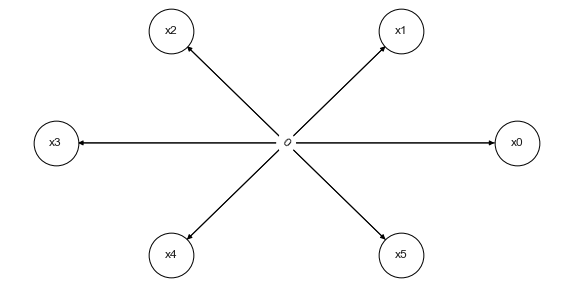

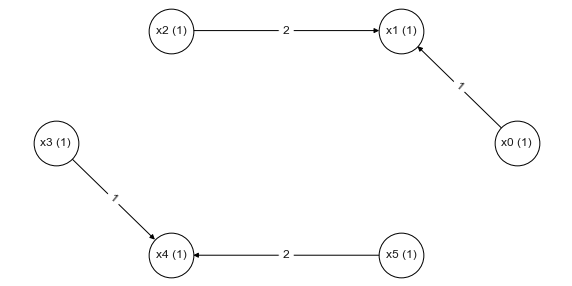

In [181]:
TCDF_solver = TCDF(significance=0.8, kernel_size=4, dilation_coefficient=4, hidden_layers=0)
TCDF_solver.fit(path_test + '/gen_ts_crash.csv', verbose=0)

TCDF_solver.get_causes()
TCDF_solver.plot_graph(ground_truth=path_test + '/gen_ts_gt.csv')

In [184]:
TCDF_solver.models['x0'].dwn.network[0].net[0].weight

Parameter containing:
tensor([[[ 0.1553,  0.1457,  0.0910,  0.4242]],

        [[ 0.0174,  0.2398,  0.4082,  0.2899]],

        [[ 0.0742,  0.1354,  0.2408,  0.3255]],

        [[-0.0092, -0.0609, -0.0844, -1.0902]],

        [[ 0.1477, -0.1849, -0.3686, -0.2724]],

        [[-0.3741, -0.0947, -0.1504, -0.4969]]], requires_grad=True)

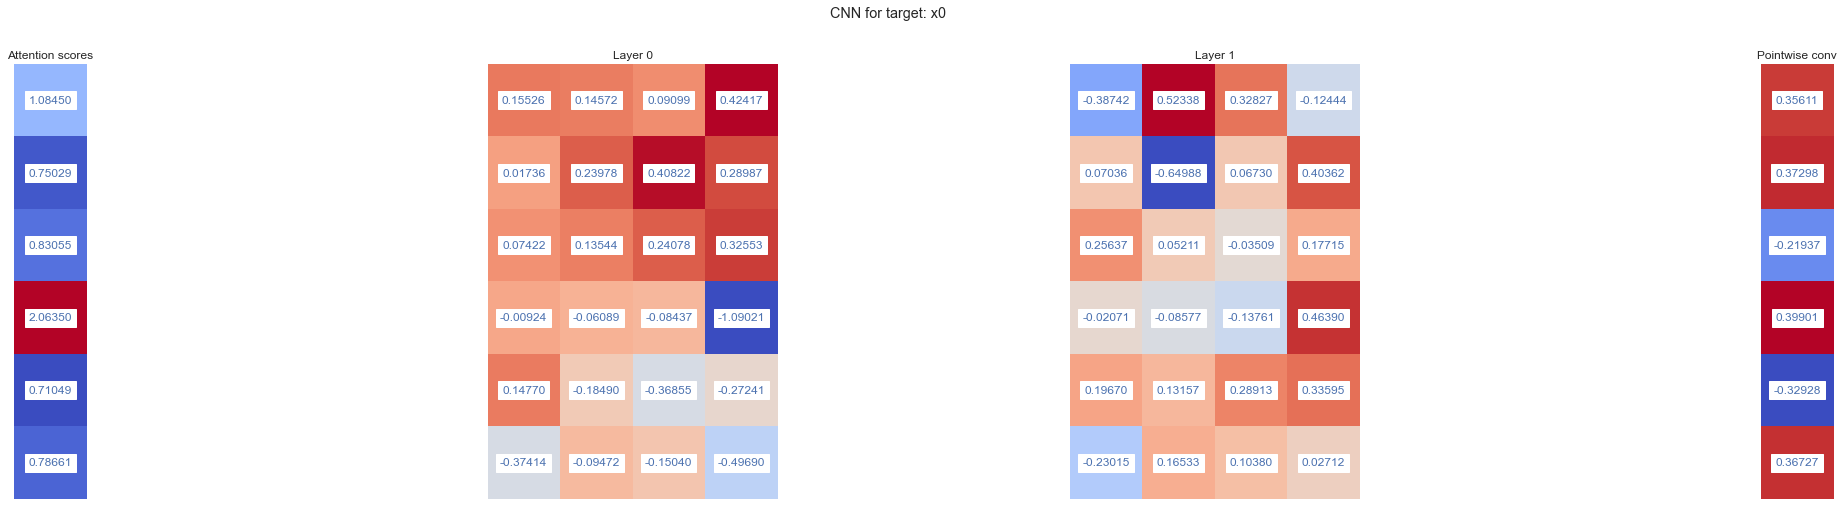

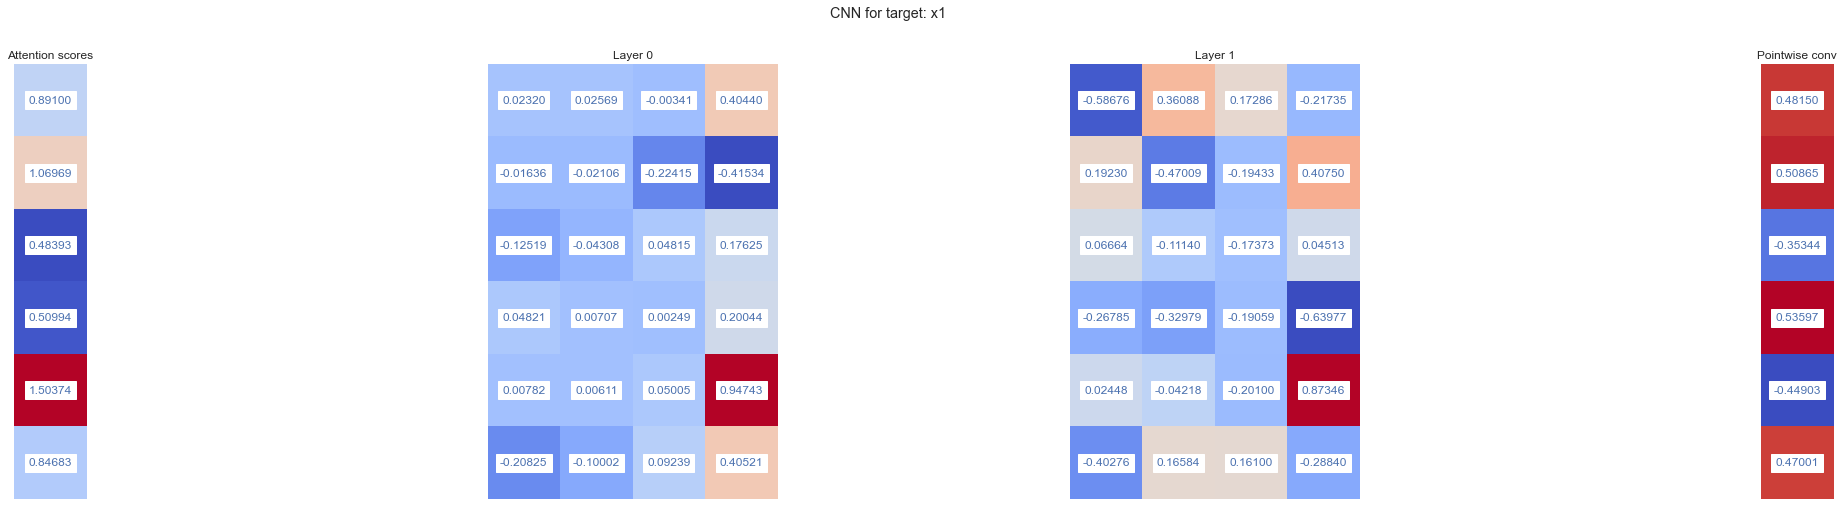

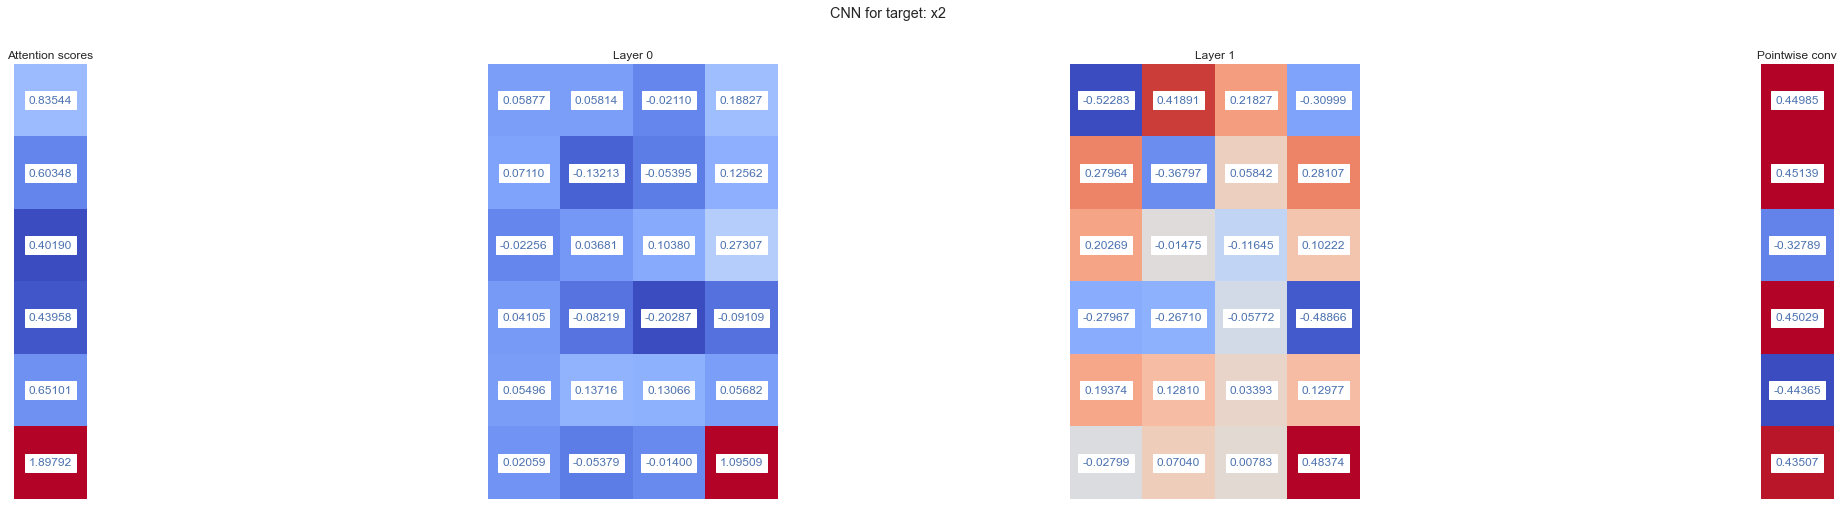

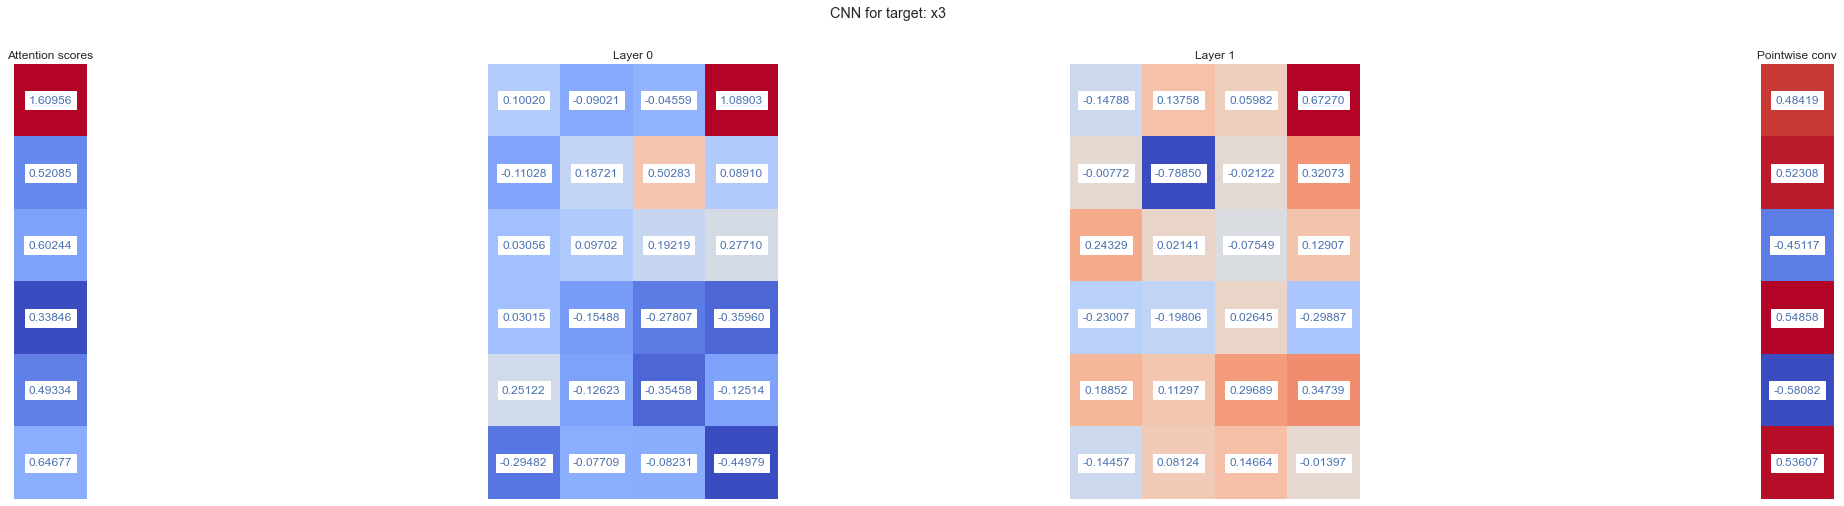

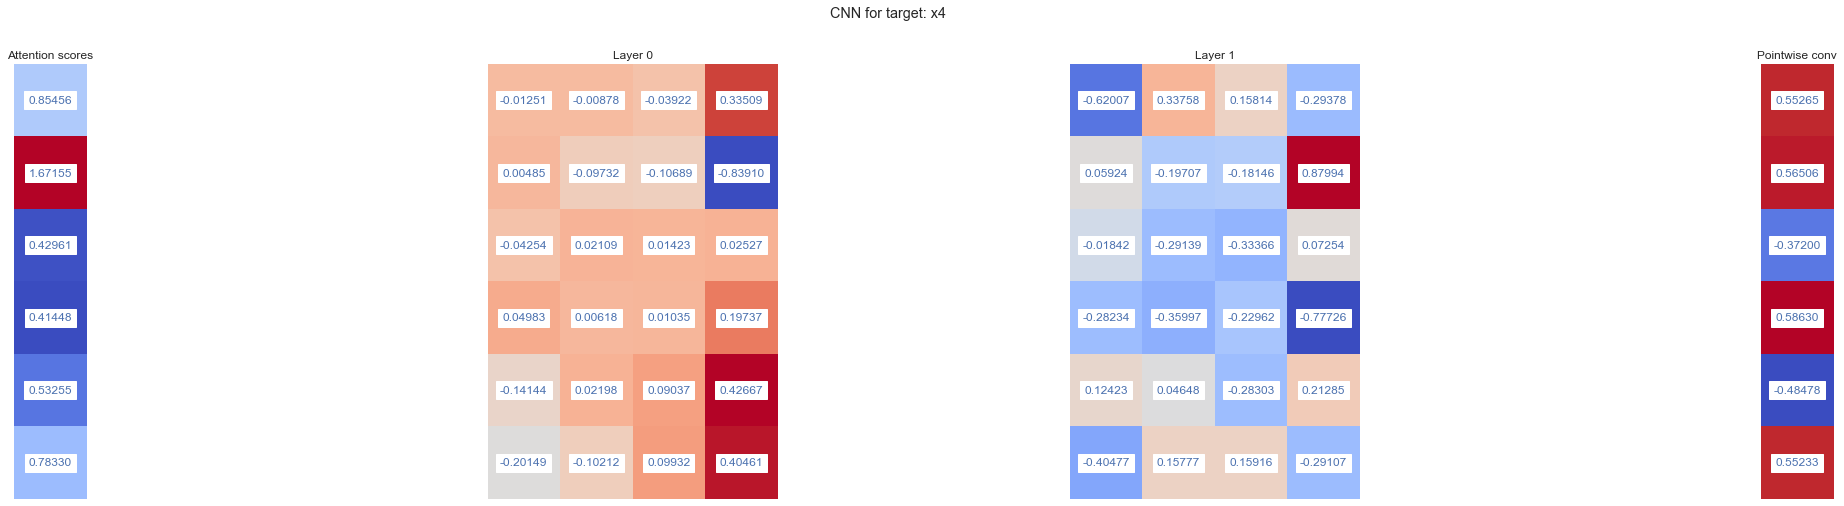

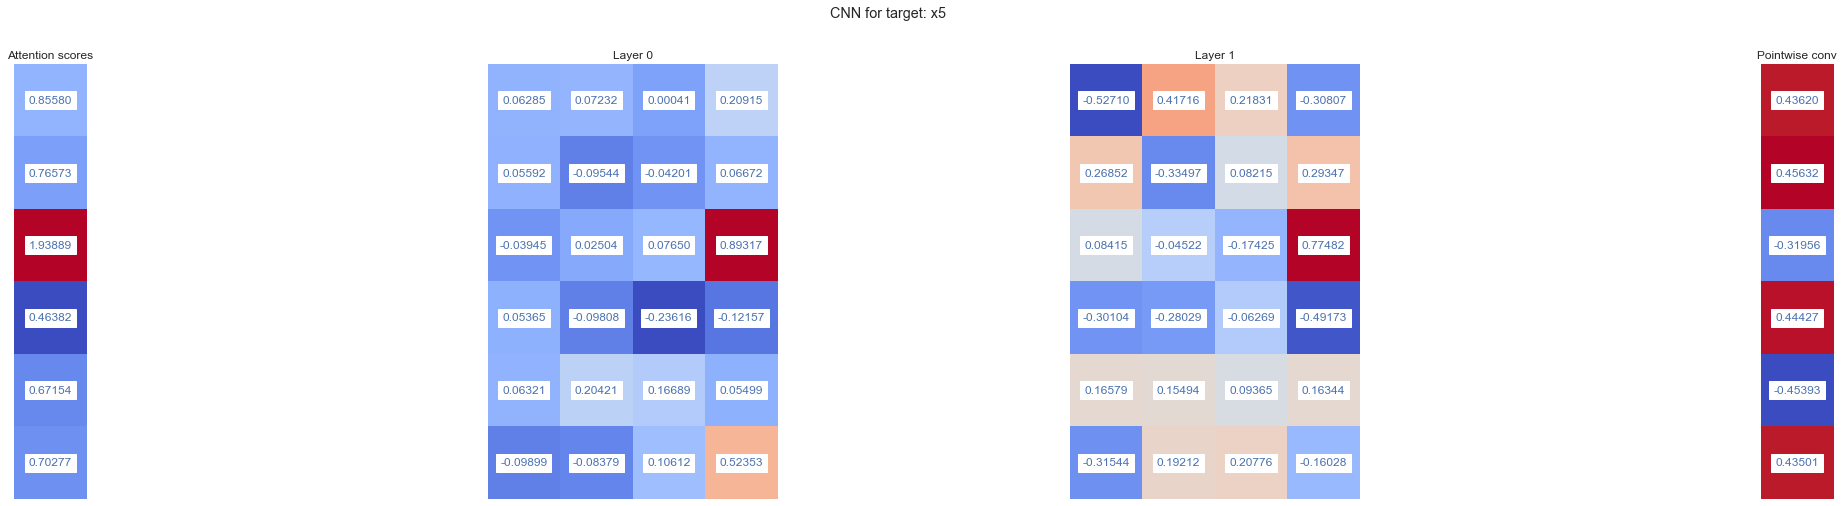

In [205]:
TCDF_solver.visualize_weights(cmap='coolwarm')  # binary, cividis, winter, plasma, copper

## Normalization test

In [5]:
links_coeffs = { 0: [((0, -1), 0.7), ((1, -1), -0.8)],
                 1: [((1, -1), 0.8), ((3, -1), 0.8)],
                 2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                 3: [((3, -1), 0.1)],
               }


data, _ = generate_ar_process(links_coeffs, 1000)
# data[:,3] *= 5

dataset = pd.DataFrame(data, columns=['x0', 'x1', 'x2', 'x3'])
dataset_gt = pd.DataFrame([[0, 0, 1],
                           [0, 1, 1],
                           [1, 1, 1],
                           [1, 3, 1],
                           [2, 2, 1],
                           [2, 1, 2],
                           [2, 3, 3],
                           [3, 3, 1]], columns=['cause', 'effect', 'delay'])

In [6]:
TCDF_solver = TCDF(significance=1.0)
TCDF_solver.fit(dataset, normalize='minmax', verbose=2)


Analysis started for target:  x0
Epoch:  1 [0%] 	Loss: 0.513962
Epoch: 500 [50%] 	Loss: 0.001381
Epoch: 1000 [100%] 	Loss: 0.001202
Potential causes: [0, 1]

⎡ diff = first_loss - real_loss
| 0.5127598525723442 = 0.5139621496200562 - 0.0012022970477119088
|
| testdiff = first_loss - test_loss
⎣ 0.48959482833743095 = 0.5139621496200562 - 0.0243673212826252


⎡ diff = first_loss - real_loss
| 0.5127598525723442 = 0.5139621496200562 - 0.0012022970477119088
|
| testdiff = first_loss - test_loss
⎣ 0.5048209046944976 = 0.5139621496200562 - 0.009141244925558567

Validated causes: [0, 1]

Analysis started for target:  x1
Epoch:  1 [0%] 	Loss: 0.419970
Epoch: 500 [50%] 	Loss: 0.007330
Epoch: 1000 [100%] 	Loss: 0.004638
Potential causes: [3, 1]

⎡ diff = first_loss - real_loss
| 0.41533182794228196 = 0.4199695289134979 - 0.004637700971215963
|
| testdiff = first_loss - test_loss
⎣ 0.4097381653264165 = 0.4199695289134979 - 0.010231363587081432


⎡ diff = first_loss - real_loss
| 0.41533182794228


======================== EVALUATION ========================

⎡ Total connections: 8
|
| Correct connections: 6
| Incorrect connections: (0, set())
| Incorrect directions: (0, set())
⎣ Undetected connections: (2, {(2, 1), (2, 2)})

⎡ Delays
|   Correct: 5
|   Incorrect AND correct direction: 1
⎣   Correct AND incorrect direction: 0





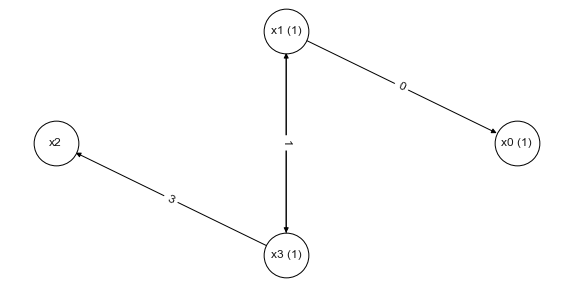

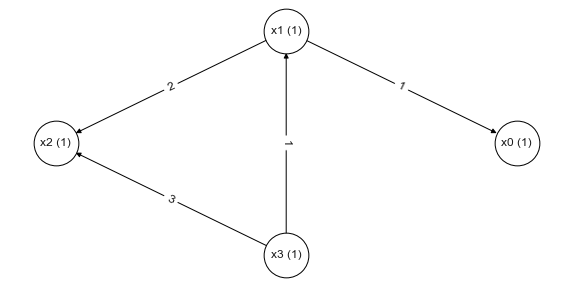

In [14]:
# TCDF_solver.get_causes()
TCDF_solver.check_with_ground_truth(dataset_gt)

# print(TCDF_solver.models['x3'].fs_attention.data.numpy())

TCDF_solver.plot_graph(ground_truth=dataset_gt)

# TCDF_solver.visualize_weights(pointwise=True, attention_scores=True)

In [8]:
TCDF_solver = TCDF(significance=1.0)
TCDF_solver.fit(dataset, normalize='std', verbose=2)


Analysis started for target:  x0
Epoch:  1 [0%] 	Loss: 1.029082
Epoch: 500 [50%] 	Loss: 0.042172
Epoch: 1000 [100%] 	Loss: 0.041534
Potential causes: [1]

⎡ diff = first_loss - real_loss
| 0.9875472746789455 = 1.0290817022323608 - 0.0415344275534153
|
| testdiff = first_loss - test_loss
⎣ 0.721630334854126 = 1.0290817022323608 - 0.30745136737823486

Validated causes: [1]

Analysis started for target:  x1
Epoch:  1 [0%] 	Loss: 1.029193
Epoch: 500 [50%] 	Loss: 0.199209
Epoch: 1000 [100%] 	Loss: 0.197496
Potential causes: [1, 3]

⎡ diff = first_loss - real_loss
| 0.8316969573497772 = 1.0291929244995117 - 0.1974959671497345
|
| testdiff = first_loss - test_loss
⎣ -0.4388629198074341 = 1.0291929244995117 - 1.4680558443069458


⎡ diff = first_loss - real_loss
| 0.8316969573497772 = 1.0291929244995117 - 0.1974959671497345
|
| testdiff = first_loss - test_loss
⎣ 0.5645641386508942 = 1.0291929244995117 - 0.46462878584861755

Validated causes: [1, 3]

Analysis started for target:  x2
Epoch:  1 


======================== EVALUATION ========================

⎡ Total connections: 8
|
| Correct connections: 4
| Incorrect connections: (0, set())
| Incorrect directions: (0, set())
⎣ Undetected connections: (4, {(0, 0), (2, 3), (3, 3), (2, 2)})

⎡ Delays
|   Correct: 4
|   Incorrect AND correct direction: 0
⎣   Correct AND incorrect direction: 0





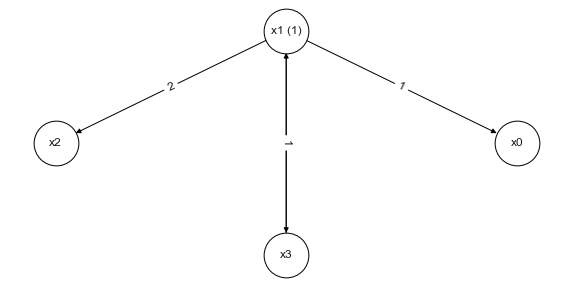

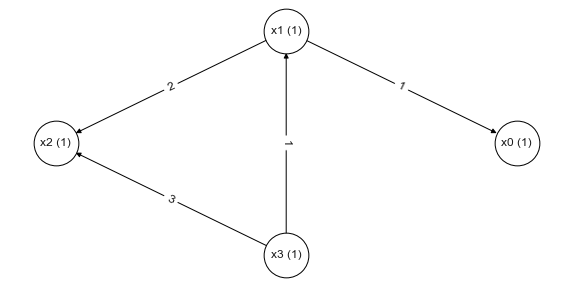

In [9]:
# TCDF_solver.get_causes()
TCDF_solver.check_with_ground_truth(dataset_gt)

# print(TCDF_solver.models['x3'].fs_attention.data.numpy())

TCDF_solver.plot_graph(ground_truth=dataset_gt)

# TCDF_solver.visualize_weights(pointwise=True, attention_scores=True)

In [10]:
TCDF_solver = TCDF()
TCDF_solver.fit(dataset, normalize=False, verbose=2)


Analysis started for target:  x0
Epoch:  1 [0%] 	Loss: 26.229969
Epoch: 500 [50%] 	Loss: 1.190865
Epoch: 1000 [100%] 	Loss: 1.058394
Potential causes: [1, 0]

⎡ diff = first_loss - real_loss
| 25.17157530784607 = 26.229969024658203 - 1.0583937168121338
|
| testdiff = first_loss - test_loss
⎣ 18.251975536346436 = 26.229969024658203 - 7.977993488311768


⎡ diff = first_loss - real_loss
| 25.17157530784607 = 26.229969024658203 - 1.0583937168121338
|
| testdiff = first_loss - test_loss
⎣ -0.1764049530029297 = 26.229969024658203 - 26.406373977661133

Validated causes: [1, 0]

Analysis started for target:  x1
Epoch:  1 [0%] 	Loss: 5.072903
Epoch: 500 [50%] 	Loss: 1.011796
Epoch: 1000 [100%] 	Loss: 0.995153
Potential causes: [1]

⎡ diff = first_loss - real_loss
| 4.077749848365784 = 5.072903156280518 - 0.9951533079147339
|
| testdiff = first_loss - test_loss
⎣ -2.396564483642578 = 5.072903156280518 - 7.469467639923096

Validated causes: [1]

Analysis started for target:  x2
Epoch:  1 [0%] 	L


======================== EVALUATION ========================

⎡ Total connections: 8
|
| Correct connections: 6
| Incorrect connections: (0, set())
| Incorrect directions: (1, {(1, 3)})
⎣ Undetected connections: (2, {(2, 3), (3, 3)})

⎡ Delays
|   Correct: 5
|   Incorrect AND correct direction: 0
⎣   Correct AND incorrect direction: 0





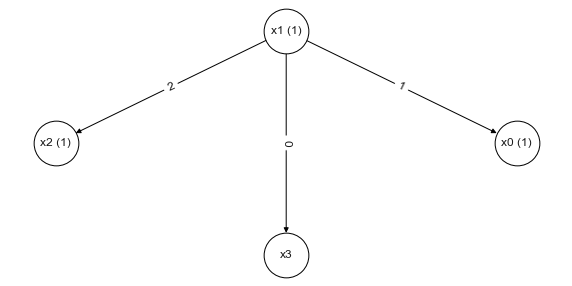

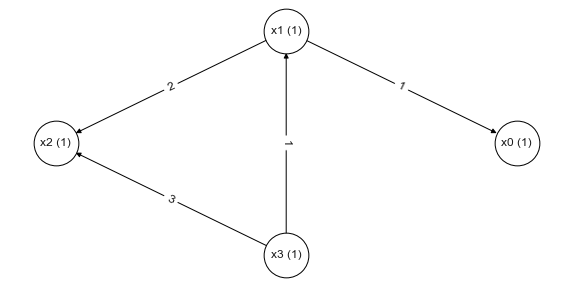

In [11]:
# TCDF_solver.get_causes()
TCDF_solver.check_with_ground_truth(dataset_gt)

# print(TCDF_solver.models['x3'].fs_attention.data.numpy())

TCDF_solver.plot_graph(ground_truth=dataset_gt)

# TCDF_solver.visualize_weights(pointwise=True, attention_scores=True)

## Tigramite tests 1

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import tigramite
import tigramite.data_processing
import tigramite.plotting

from tigramite.independence_tests import ParCorr
from tigramite.pcmci import PCMCI

sns.set(style='darkgrid')

path_project = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_datasets = path_project + '/datasets'

def generate_ar_process(links_coeffs, time_steps, seed=None):
  if seed is not None:
    np.random.seed(seed)
  return tigramite.data_processing.var_process(links_coeffs, T=time_steps)

def binarize(array, threshold):
  thresholds = np.full(data.shape, threshold)
  binarized = np.empty(data.shape)

  for slice in range(data.shape[1]):
    binarized[:, slice] = list(map(lambda x: 1 if x == True else 0, (data > thresholds)[:, slice]))
  return binarized

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Could not import sklearn for GPACE
Could not import r-package RCIT
Could not import r-package acepack for GPACE, use python ACE package
Could not import python ACE package for GPACE
Could not import statsmodels, p-value corrections not available.


In [ ]:
time_steps, num_timeseries = 1000, 4 # exactly data.shape
time_grid = np.arange(time_steps)
var_names = ['$X^0$', '$X^1$', '$X^2$', '$X^3$']
links_coeffs = { 0: [((0, -1), 0.7), ((1, -1), -0.8)],
                 1: [((1, -1), 0.8), ((3, -1), 0.8)],
                 2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                 3: [((3, -1), 0.1)],
               }

data, true_parents_neighbors = generate_ar_process(links_coeffs, time_steps)
dataframe = tigramite.data_processing.DataFrame(data)

# data_binarized = binarize(data, 0.5)
# dataframe_binarized = tigramite.data_processing.DataFrame(data_binarized)

Could not import sklearn for GPACE
Could not import r-package RCIT
Could not import r-package acepack for GPACE, use python ACE package
Could not import python ACE package for GPACE
Could not import statsmodels, p-value corrections not available.

## Estimating lagged dependencies


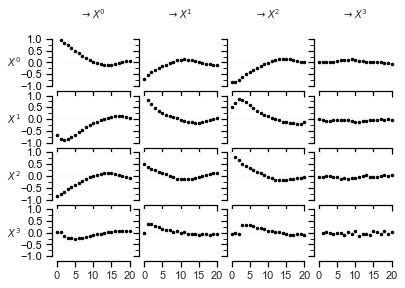

In [46]:


parcorr = ParCorr(significance='analytic')

pcmci = PCMCI(dataframe=dataframe,
              cond_ind_test=parcorr,
              verbosity=1)

correlations = pcmci.get_lagged_dependencies(tau_max=20)

lag_func_matrix = tigramite.plotting.plot_lagfuncs(val_matrix=correlations,
                                                   setup_args={'var_names':var_names,
                                                               'x_base':5, 'y_base':.5})

pcmci.verbosity = 0
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)

plotting time series from first dynamical system


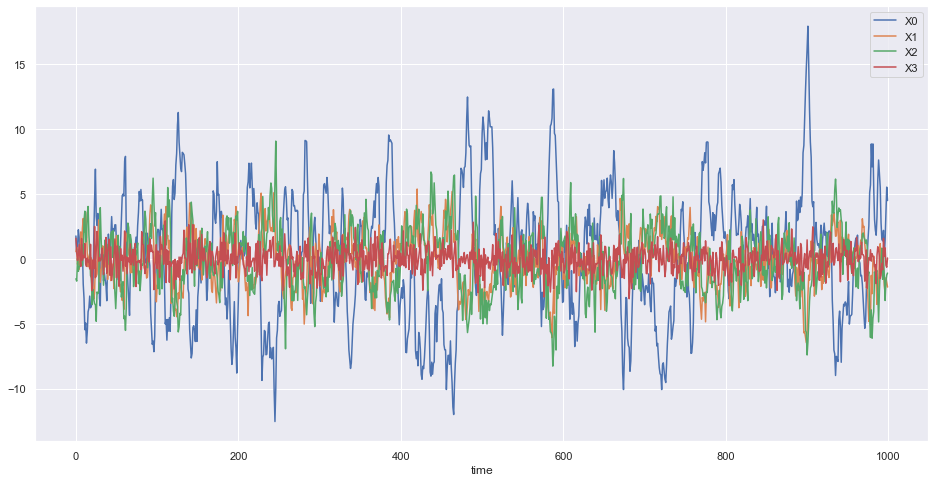

In [14]:
# tigramite.plotting.plot_timeseries(data, time_grid, var_names)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

print('plotting time series from first dynamical system')
ax.plot(dataframe.values[:,0])
ax.plot(dataframe.values[:,1])
ax.plot(dataframe.values[:,2])
ax.plot(dataframe.values[:,3])
ax.legend(['X0', 'X1', 'X2', 'X3'])

ax.set_xlabel('time')

plt.show()

plotting discrete time series


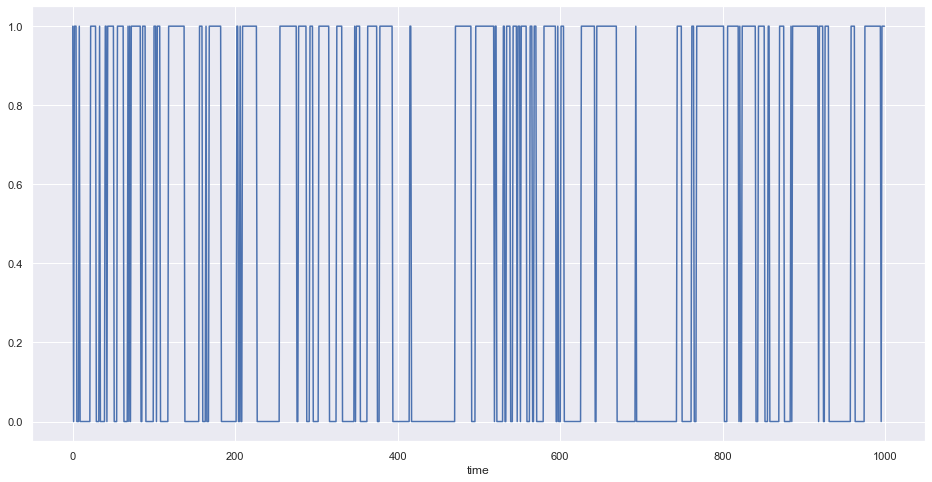

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

print('plotting discrete time series')
ax.plot(dataframe_binarized.values[:, 0])

ax.set_xlabel('time')

plt.show()

## Tigramite's PCMCI vs TCDF

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Generate dataset

In [ ]:
time_steps, num_timeseries = 1000, 4 # exactly data.shape
time_grid = np.arange(time_steps)

links_coeffs = { 0: [((0, -1), 0.7), ((1, -1), -0.8)],
                 1: [((1, -1), 0.8), ((3, -1), 0.8)],
                 2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                 3: [((3, -1), 0.1)],
               }
var_names = ['x0', 'x1', 'x2', 'x3']

data, true_parents_neighbors = generate_ar_process(links_coeffs, time_steps)
# data_binarized = binarize(data, 0.5)

np.savetxt(path_datasets + '/generated/gen_ts.csv',
           data,
           header=','.join(var_names),
           comments='',
           delimiter=',')

### TCDF comparison

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# =====================================================

path_project = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_tcdf = path_project + '/src'
path_datasets = path_project + '/datasets'
path_tcdf_bash = path_tcdf.replace(' ', '\\ ')
path_datasets_bash = path_datasets.replace(' ', '\\ ')
sys.path.append(path_tcdf)
from TCDF_wrapper import TCDF

# =====================================================

dataset = path_datasets + '/generated/gen_ts.csv'
dataset_gt = path_datasets + '/generated/gen_ts_groundtruth_true.csv'

# dataset = path_datasets + '/demo_dataset.csv'
# dataset_gt = path_datasets + '/demo_groundtruth.csv'

# dataset = path_datasets + '/fMRI/timeseries1.csv'
# dataset_gt = path_datasets + '/fMRI/sim1_gt_processed.csv'

# dataset = path_datasets + '/Finance/random-rels_20_1_3_returns30007000_header.csv'
# dataset_gt = path_datasets + '/Finance/random-rels_20_1_3.csv'

# dataset = path_datasets + '/Finance/random-rels_40_1_3_returns30007000_header.csv'
# dataset_gt = path_datasets + '/Finance/random-rels_40_1_3.csv'

TCDF_solver = TCDF(
    significance=1.0,
    intervention='perm',
    kernel_size=4,
    dilation_coefficient=4,
    hidden_layers=0,
    epochs=1000)
TCDF_solver.fit(dataset, normalize='minmax', verbose=1)

TCDF_solver.get_causes(graphical=True)
TCDF_solver.check_with_ground_truth(dataset_gt)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Analysis started for target:  x0
Potential causes: [0, 1]


Validated causes: [0, 1]

Analysis started for target:  x1
Potential causes: [1, 3]


Validated causes: [1, 3]

Analysis started for target:  x2
Potential causes: [1, 2]


Validated causes: [1, 2]

Analysis started for target:  x3
Potential causes: [1, 0, 2]


Validated causes: [1, 0, 2]

========================== RESULTS =========================

x0 ---> x0 (d = 1)
x1 ---> x0 (d = 1)
x1 ---> x1 (d = 1)
x3 ---> x1 (d = 1)
x1 ---> x2 (d = 2)
x2 ---> x2 (d = 1)
x1 ---> x3 (d = 3)
x0 ---> x3 (d = 0)
x2 ---> x3 (d = 0)



======================== EVALUATION ========================

⎡ Total directions: 8
| 
| Correct connections: 7
| Correct directions: 6
| Incorrect connections: [1, {(0, 3)}]
| Incorrect directions: [2, {(3, 2), (3, 1)}]
⎣ Undetected connections: [1, {(3, 3)}]


⎡ Delays
| 
| Correct: 6
| Incorrect AND correct direction: [0

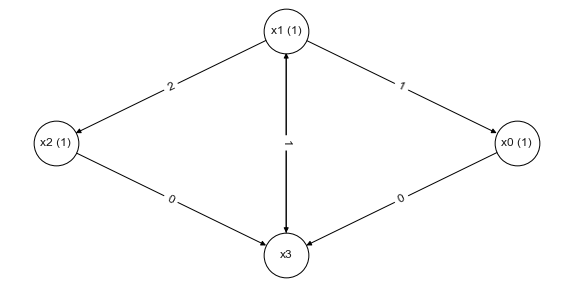

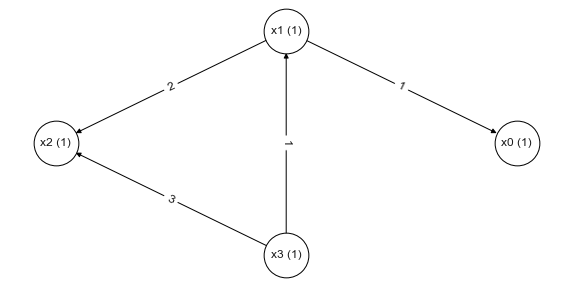

In [7]:
TCDF_solver.plot_graph(ground_truth=dataset_gt)

In [9]:
print('heh')

heh


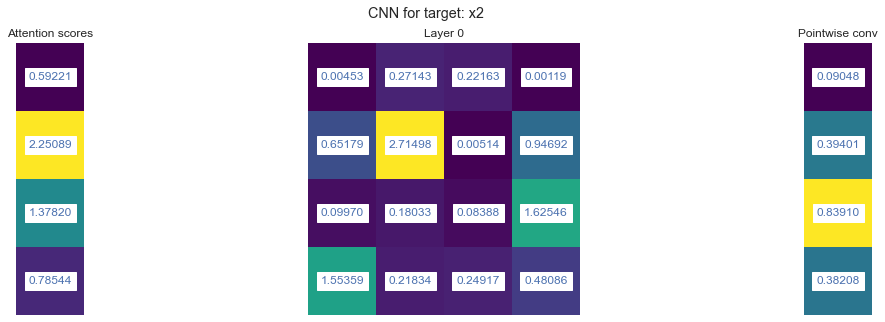

In [8]:
TCDF_solver.visualize_weights(targets='x2', absolute=True)

In [109]:
import tigramite
import tigramite.data_processing
from tigramite.independence_tests import ParCorr
from tigramite.pcmci import PCMCI

# data = pd.read_csv(dataset)
data = tigramite.data_processing.DataFrame(data.to_numpy())
# tigramite.plotting.plot_timeseries(data)

parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=data_tg, cond_ind_test=parcorr, verbosity=0)
results = pcmci.run_pcmci(tau_max=4, pc_alpha=1.0)

print(results.keys())

pcmci._print_significant_links(p_matrix = results['p_matrix'],
                              val_matrix = results['val_matrix'],
                              alpha_level = 0.01)

Could not import sklearn for GPACE
Could not import r-package RCIT
Could not import r-package acepack for GPACE, use python ACE package
Could not import python ACE package for GPACE
Could not import statsmodels, p-value corrections not available.


KeyboardInterrupt: 

In [53]:
import torch
heh = torch.Tensor([1, 2, 3, 4, 4])
result = (heh == max(heh)).nonzero().flatten().tolist()
print(result)

import heapq
result = heapq.nlargest(2, heh)
print(result)

result = [i for i, j in enumerate(heh) if j == max(heh)]
print(result)

result = max(range(row_len), key=heh.__getitem__)
print(result)

[3, 4]
[tensor(4.), tensor(4.)]
[3, 4]
3


[tensor(4.), tensor(3.)]

{(1, 0): 1, (0, 0): 1, (3, 1): 1, (1, 1): 2, (2, 2): 1, (1, 2): 1, (3, 3): 2, (0, 3): 0}


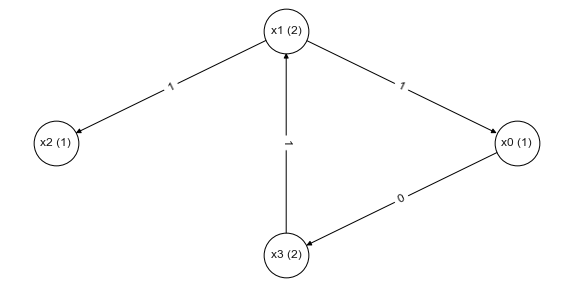

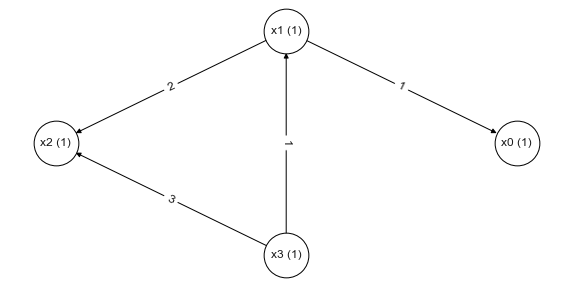

In [114]:
TCDF_solver.plot_graph(print_delays=True, ground_truth=dataset_gt)